## Set up
### Importing libraries

In [3]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression, Ridge, Lasso

### Data load & enrichment

In [5]:
data_folder = '.'

additional_features = pd.read_csv(f"{data_folder}/data.csv").drop("Id", axis=1)
additional_features = additional_features.fillna(additional_features.mean())
additional_features = additional_features.fillna('N/A')
base_features = pd.read_csv(f"{data_folder}/Houseprice_data_scaled.csv")

### Parameters & Constants

In [18]:
# Params
SHOW_CAT_TO_NUM_WARNING = False
ADDITIONAL_FEATURES_SELECT = ['MSZoning', 'MSSubClass']
LAMBDA_RIDGE = 0.1
LAMBDA_LASSO = 0.04
N_SIMULATIONS = 1000

# Constants
ADDITIONAL_FEATURES_FIXED = ['LotFrontage', 'LotShape']
ADDITIONAL_FEATURES = ADDITIONAL_FEATURES_FIXED + ADDITIONAL_FEATURES_SELECT

### Helper functions

In [64]:
def add_features(base, feature_name):
    """ 
    Outputs a dataframe which equals base_features plus any feature_name from additional_features. 
    Any categorical features will be naively converts to numerical values. All the feature values will be scaled.
    Any missing values (N/A) are filled with average values for this feature
    """
    rep_base = base.copy()
    def add_single_feature(single_feature):
        if is_numeric_dtype(additional_features[single_feature].dtype):
            rep_base[single_feature] = additional_features[single_feature]
        else:
            flist = np.setdiff1d(additional_features[single_feature].unique(), ['N/A'])
            f_map = dict(zip(flist, range(len(flist))))
            if SHOW_CAT_TO_NUM_WARNING:
                print("Warning: feature {} is categorical. Mapping to numerical...".format(single_feature))
                print("Mapping: {}".format(f_map))    
            rep_base[single_feature] = additional_features[single_feature].map(f_map)
            # TODO: what to do for NA in categorical features?
            rep_base[single_feature] = rep_base[single_feature].replace('N/A', np.nan)
            rep_base[single_feature] = rep_base[single_feature].fillna(rep_base[single_feature].mean())
        rep_base[single_feature] = (rep_base[single_feature] - rep_base[single_feature].mean()) / rep_base[single_feature].std()
    if type(feature_name) == str:
        add_single_feature(feature_name)
    elif type(feature_name) == list:
        for f in feature_name:
            add_single_feature(f)
    return rep_base

def split_dataset(dataset, random=False):
    """ Split input dataset into training, validation and test set (in this order) of size 1800, 600 and whatever left """
    idx_lst = np.arange(len(dataset))
    if random:
        np.random.shuffle(idx_lst)
    train_idx = idx_lst[:1800]
    val_idx = idx_lst[1800:1800+600]
    test_idx = idx_lst[1800+600:len(dataset)]
    return dataset.iloc[train_idx], dataset.iloc[val_idx], dataset.iloc[test_idx]

def split_xy(dataset, value_name="Sale Price"):
    """ Split input data set into feature and value """
    return dataset.drop(value_name, axis=1), dataset[[value_name]]

def regression(features, method='linear', alpha=0, random=False):
    """ 
    Run a regression of choice with additional features added to base_features
    
    :param features: A list of features available in dataframe additional_features
    :param method: One of "linear", "ridge" or "lasso"
    :param alpha: Alpha pamameter used for ridge or lasso regression. Should be lambda in Hull's book times # of 
                  observations for ridge regression or half of lambda for lasso regression.
    :param random: Whether to split training/validation/test data sets randomly or not
    
    :return: A dictionary containing coeffients and model mse
    """
    # Select features
    df = add_features(base_features, ADDITIONAL_FEATURES)
    
    # Split data set and split each into X and y where y is the price, and X is set of features
    train, val, test = [split_xy(x) for x in split_dataset(df, random=random)]
    
    # Fit model
    def fit_model(alpha):
        reg_model = {
            'linear': LinearRegression(),
            'ridge': Ridge(alpha=alpha),
            'lasso': Lasso(alpha=alpha),
        }[method.lower()]
        reg_model.fit(*train)
    
        return {
            'coeffs': pd.DataFrame(
                [
                    ['intercept'] + list(train[0]),
                    list(reg_model.intercept_) + list(reg_model.coef_ if method == 'lasso' else reg_model.coef_[0])
                ]
            ).transpose().set_index(0),
            'mse': mse(val[1], reg_model.predict(val[0])),
        }
    
    try:
        return fit_model(float(alpha))
    except TypeError:
        return [fit_model(float(a)) for a in alpha]

def monte_carlo(features, n_simulations, method="linear", alpha=0):
    """
    Run Monte Carlo simulations for a particular regression method and output the average mses and coeffs
    """
    def mc_single_alpha(features, n_simulations, method, alpha):
        coeffs = []
        mses = []
        for i in range(n_simulations):
            rs = regression(features, method=method, alpha=alpha, random=True)
            coeffs.append(rs['coeffs'])
            mses.append(rs['mse'])    
        return {
            'coeffs': pd.DataFrame(pd.concat(coeffs, axis=1).mean(axis=1)),
            'mse': np.array(mses).mean(),
        }
    try:
        return mc_single_alpha(features, n_simulations, method, float(alpha))
    except TypeError:
        return [mc_single_alpha(features, n_simulations, method, float(a)) for a in alpha]

## Regression Analysis I

Use first 1800 as training set, next 800 as validation set and the rest as test set  

### Linear Regression

In [8]:
regression(ADDITIONAL_FEATURES_SELECT, method='linear')['coeffs']

,1
0,
intercept,-0.0145748
LotArea,0.0614796
OverallQual,0.211643
OverallCond,0.0879999
YearBuilt,0.162659
YearRemodAdd,0.0262192
BsmtFinSF1,0.0982617
BsmtUnfSF,-0.0369657
TotalBsmtSF,0.114031


### Ridge Regression

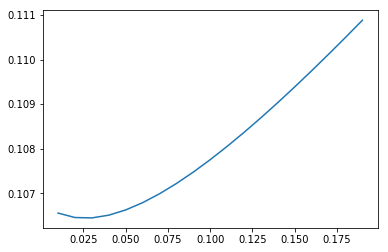

,1
0,
intercept,-0.0147715
LotArea,0.0559309
OverallQual,0.193224
OverallCond,0.0693546
YearBuilt,0.105469
YearRemodAdd,0.0467749
BsmtFinSF1,0.104148
BsmtUnfSF,-0.022468
TotalBsmtSF,0.0972576


In [14]:
lambdas = np.arange(0.01, 0.2, 0.01)
alphas = lambdas * 1800

mses = [x['mse'] for x in regression(ADDITIONAL_FEATURES_SELECT, method='ridge', alpha=alphas)]

plt.plot(lambdas, mses)
plt.show()

regression(ADDITIONAL_FEATURES_SELECT, method='ridge', alpha=LAMBDA_RIDGE*1800)['coeffs']

### Lasso Regression

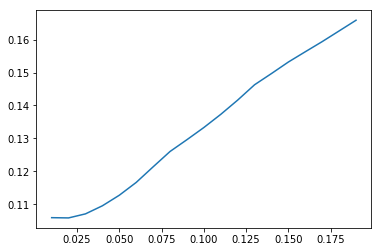

,1
0,
intercept,-0.0142667
LotArea,0.0527082
OverallQual,0.254299
OverallCond,0.0419465
YearBuilt,0.106387
YearRemodAdd,0.0480002
BsmtFinSF1,0.124145
BsmtUnfSF,-0
TotalBsmtSF,0.0840229


In [15]:
lambdas = np.arange(0.01, 0.2, 0.01)
alphas = lambdas / 2

mses = [x['mse'] for x in regression(ADDITIONAL_FEATURES_SELECT, method='lasso', alpha=alphas)]

plt.plot(lambdas, mses)
plt.show()

regression(ADDITIONAL_FEATURES_SELECT, method='lasso', alpha=LAMBDA_LASSO/2)['coeffs']

## Regression Analysis II

Randomly determine training set, validation set and test set  
TODO: MONTE CARLO THIS SHIT!

### Linear Regression

In [66]:
monte_carlo(ADDITIONAL_FEATURES_SELECT, N_SIMULATIONS, method='linear')['coeffs']

,0
0,
intercept,4.422683e-05
LotArea,6.467318e-02
OverallQual,2.243563e-01
OverallCond,7.945630e-02
YearBuilt,1.611990e-01
YearRemodAdd,3.513384e-02
BsmtFinSF1,8.563648e-02
BsmtUnfSF,-5.784797e-02
TotalBsmtSF,1.240338e-01


### Ridge Regression

In [67]:
lambdas = np.arange(0.01, 0.2, 0.01)
alphas = lambdas * 1800

mses = [x['mse'] for x in monte_carlo(ADDITIONAL_FEATURES_SELECT, N_SIMULATIONS, method='ridge', alpha=alphas)]

plt.plot(lambdas, mses)
plt.show()

monte_carlo(ADDITIONAL_FEATURES_SELECT, method='ridge', alpha=LAMBDA_RIDGE*1800)['coeffs']

KeyboardInterrupt: 

### Lasso Regression

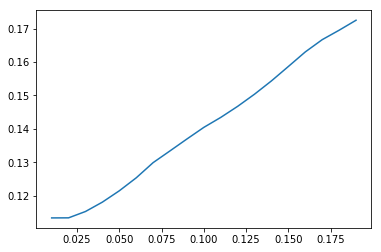

,1
0,
intercept,-0.00431199
LotArea,0.045283
OverallQual,0.261234
OverallCond,0.0389292
YearBuilt,0.0909414
YearRemodAdd,0.0496887
BsmtFinSF1,0.13903
BsmtUnfSF,-0
TotalBsmtSF,0.073512


In [17]:
lambdas = np.arange(0.01, 0.2, 0.01)
alphas = lambdas / 2

mses = [x['mse'] for x in monte_carlo(ADDITIONAL_FEATURES_SELECT, method='lasso', alpha=alphas)]

plt.plot(lambdas, mses)
plt.show()

monte_carlo(ADDITIONAL_FEATURES_SELECT, method='lasso', alpha=LAMBDA_LASSO/2)['coeffs']

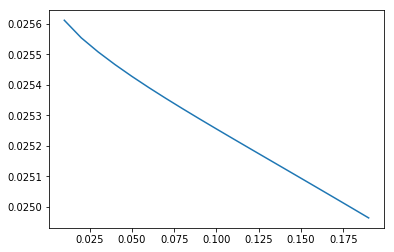

In [76]:
# Yvonne's for loop

lambdas = np.arange(0.01, 0.2, 0.01)
alphas = lambdas * 1800

plt.plot(lambdas, [float(shit['coeffs'].mean()) for shit in regression(ADDITIONAL_FEATURES_SELECT, method='ridge', alpha=alphas)])
plt.show()